<a href="https://colab.research.google.com/github/VvS-2403/smart-obesity-predictor/blob/main/AudioDenoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Converted trumpet.mp3 → trumpet.wav
Loaded: trumpet.wav sr= 16000 samples= 33024
Noisy audio saved: trumpet_noisy.wav
Denoised audio saved: trumpet_denoised.wav


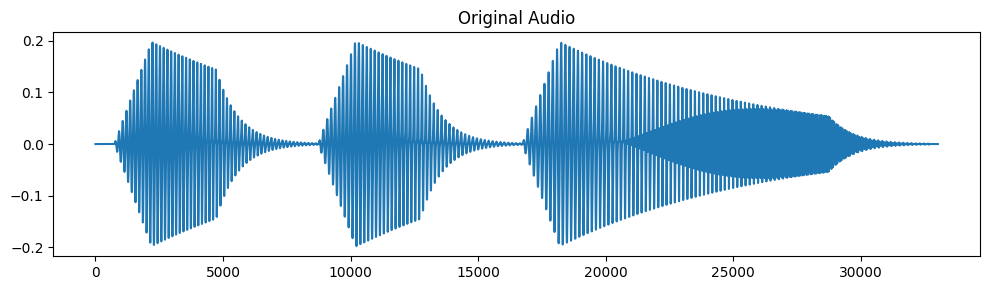

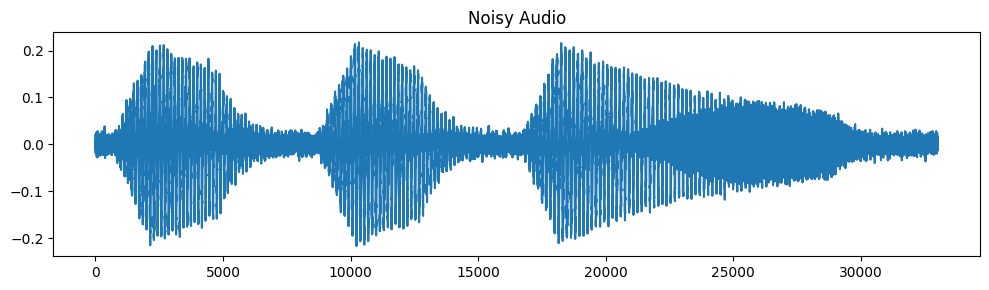

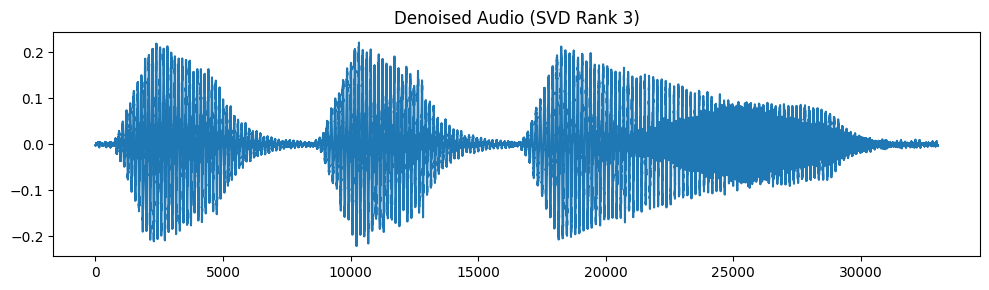

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment
import os


# 1. USER INPUT FILE


INPUT_MP3 = "trumpet.mp3"          # <-- your MP3 file in same directory
WAV_FILE = "trumpet.wav"
NOISY_FILE = "trumpet_noisy.wav"
DENOISED_FILE = "trumpet_denoised.wav"


# 2. MP3 → WAV CONVERSION (pydub)

audio = AudioSegment.from_file(INPUT_MP3)
audio = audio.set_channels(1).set_frame_rate(16000)   # mono 16kHz
audio.export(WAV_FILE, format="wav")

print(f"Converted {INPUT_MP3} → {WAV_FILE}")


# 3. LOAD WAV USING SCIPY

sr, y = wavfile.read(WAV_FILE)

# Convert to float32
if y.dtype == np.int16:
    y = y.astype(np.float32) / 32768.0
elif y.dtype == np.int32:
    y = y.astype(np.float32) / 2147483648.0
else:
    y = y.astype(np.float32)

print("Loaded:", WAV_FILE, "sr=", sr, "samples=", len(y))


# 4. ADD SMALL NOISE

noise = 0.01 * np.random.randn(len(y))
y_noisy = y + noise

# Save noisy audio
y_noisy_pcm = np.clip(y_noisy, -1, 1)
y_noisy_pcm = (y_noisy_pcm * 32767).astype(np.int16)
wavfile.write(NOISY_FILE, sr, y_noisy_pcm)

print("Noisy audio saved:", NOISY_FILE)


# 5. SIMPLE SVD DENOISING USING STFT


# STFT
f, t, Zxx = signal.stft(y_noisy, fs=sr, nperseg=1024, noverlap=512)

mag = np.abs(Zxx)
phase = np.angle(Zxx)

# SVD on magnitude
U, S, Vt = np.linalg.svd(mag, full_matrices=False)

# Keep only rank 3
r = 3
mag_den = (U[:, :r] * S[:r]) @ Vt[:r, :]

# Reconstruct complex spectrogram
Zxx_den = mag_den * np.exp(1j * phase)

# Inverse STFT
_, y_den = signal.istft(Zxx_den, fs=sr, nperseg=1024, noverlap=512)

# Trim
y_den = y_den[:len(y)]

# Save denoised audio
y_den_pcm = np.clip(y_den, -1, 1)
y_den_pcm = (y_den_pcm * 32767).astype(np.int16)
wavfile.write(DENOISED_FILE, sr, y_den_pcm)

print("Denoised audio saved:", DENOISED_FILE)


# 6. PLOTS


plt.figure(figsize=(10,3))
plt.plot(y)
plt.title("Original Audio")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(y_noisy)
plt.title("Noisy Audio")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(y_den)
plt.title("Denoised Audio (SVD Rank 3)")
plt.tight_layout()
plt.show()

